# SPM impact of Alaska's Permanent Fund Dividend

Difference in differences using 1982, the first year of the PFD where it was \$1,000 per person.

## Setup

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import microdf as mdf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mdf.set_plot_style()

## Load data

In [3]:
dat = pd.read_csv('data/spm_state.csv.gz')
pfd = pd.read_csv('data/pfd_amounts.csv')

## Preprocess

Add DD columns. Alaska is state FIPS code 2,
but [prior to 1976](https://cps.ipums.org/cps-action/variables/STATEFIP#comparability_section),
some states [shared](https://cps.ipums.org/cps-action/variables/STATEFIP#codes_section) FIPS codes.
These are all codes that have represented Alaska:
* 68: Alaska-Hawaii
* 80: Alaska-Washington-Hawaii
* 88: Washington-Oregon-Alaska-Hawaii

In [4]:
AK_FIPS = [2, 68, 80, 88]

Show which code represented Alaska in each year.

In [5]:
dat[dat.statefip.isin(AK_FIPS) &
    (dat.year < 1976)].groupby('year').statefip.min()

year
1967    80
1968    80
1969    80
1970    80
1971    80
1972    88
1973    88
1974    88
1975    88
Name: statefip, dtype: int64

Drop data before 1976 to avoid combining with other states.
The first PFD check was in 1982, so this still gives 6 years of pre-period.

In [6]:
YEAR_START = 1976

In [7]:
dat = dat[dat.year >= YEAR_START]

In [8]:
dat['alaska'] = dat.statefip == 2
dat['post'] = dat.year >= 1982
dat['alaska_post'] = dat.alaska & dat.post

Set bools to ints for regressions, and add a constant.

In [9]:
dat.replace(False, 0, inplace=True)

In [10]:
dat = sm.add_constant(dat)

Add polynomials and interactions as controls.

In [11]:
dat['age2'] = dat.age * dat.age
dat['female_age'] = dat.female * dat.age
dat['female_age2'] = dat.female * dat.age2

Simplest model just compares two years.

In [12]:
dat8182 = dat[dat.year.isin([1981, 1982])]

## Graphs

In [13]:
dat['poorw'] = dat.poor * dat.w

In [14]:
povtrend = dat.groupby('year')[['poorw', 'w']].sum()
povtrend['pov_rate'] = povtrend.poorw / povtrend.w

In [15]:
povtrend_ak = dat.groupby(['year', 'alaska'])[['poorw', 'w']].sum()
povtrend_ak['pov_rate'] = povtrend_ak.poorw / povtrend_ak.w
# Pivot, rename columns, and reorder.
povtrend_ak = povtrend_ak.pivot_table('pov_rate', 'year', 'alaska')
povtrend_ak.columns = ['rest', 'ak']
povtrend_ak = povtrend_ak[['ak', 'rest']]

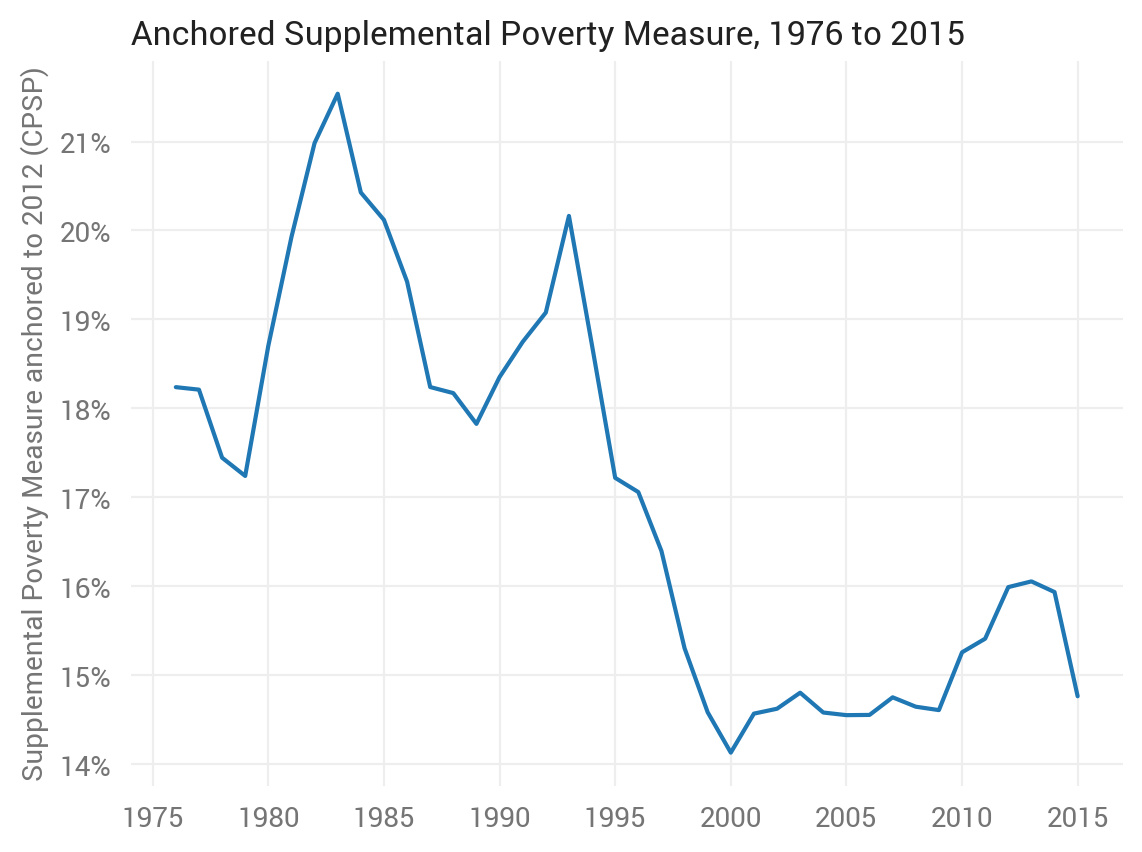

In [16]:
ax = povtrend.pov_rate.plot()
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
plt.xlabel('')
plt.ylabel('Supplemental Poverty Measure anchored to 2012 (CPSP)')
plt.title('Anchored Supplemental Poverty Measure, ' + str(YEAR_START) + 
          ' to 2015', loc='left')
plt.show()

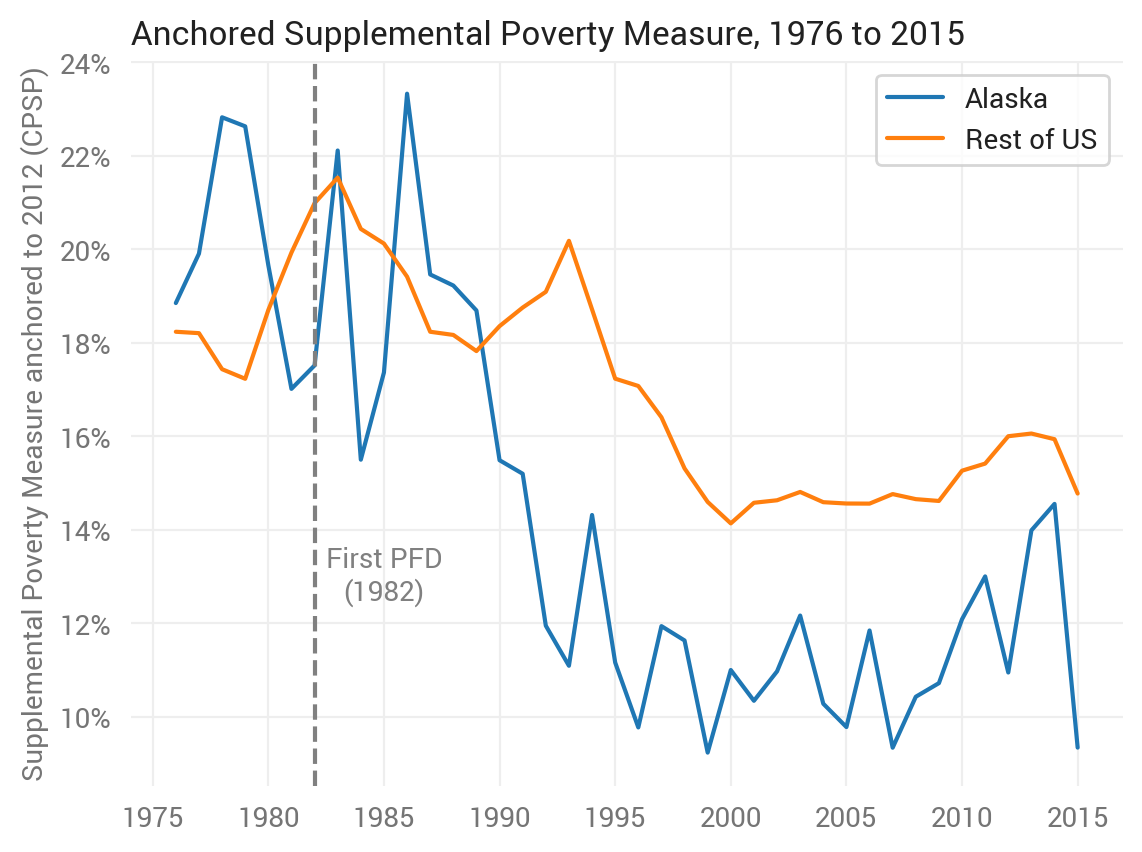

In [17]:
ax = povtrend_ak.plot()
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
plt.legend(['Alaska', 'Rest of US'])
plt.xlabel('')
ax.axvline(1982, c='gray', linestyle='--')
plt.text(1985, 0.125, 'First PFD\n(1982)',
         horizontalalignment='center', zorder=10, c='gray')
plt.ylabel('Supplemental Poverty Measure anchored to 2012 (CPSP)')
plt.title('Anchored Supplemental Poverty Measure, ' + str(YEAR_START) + 
          ' to 2015', loc='left')
plt.show()

## Regression

In [18]:
DD_VARS = ['alaska_post', 'alaska', 'post', 'const']
CONTROLS = ['female', 'age', 'age2', 'female_age', 'female_age2']

In [19]:
m1 = sm.WLS(dat8182.poor, dat8182[DD_VARS]).fit(cov_type='HC1')  # Robust SEs.
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     37.83
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           1.97e-24
Time:                        19:52:05   Log-Likelihood:            -1.7048e+05
No. Observations:              324822   AIC:                         3.410e+05
Df Residuals:                  324818   BIC:                         3.410e+05
Df Model:                           3                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
alaska_post     0.0018      0.011      0.160      0.873      -0.020       0.024
alaska         -0.0392      0.008     -4.890      0.000      -0.055      -0.023
post            0.0118      0.001      8.155      0.000       0.009       0.015
const           0.2071      0.001    204.535      0.000       0.205       0.209
==============================================================================
Omnibus:                    62082.782   Durbin-Watson:                   1.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106904.847
Skew:                           1.405   Prob(JB):                         0.00
Kurtosis:                       2.977   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Clustered standard errors cause rank deficiency:

In [20]:
m_clust = sm.WLS(dat8182.poor, dat8182[DD_VARS]).fit(
    cov_type='cluster', cov_kwds={'groups': dat8182.alaska})
m_clust.summary()

/home/mghenis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                 6.171e+23
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           9.00e-13
Time:                        19:52:05   Log-Likelihood:            -1.7048e+05
No. Observations:              324822   AIC:                         3.410e+05
Df Residuals:                  324818   BIC:                         3.410e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
alaska_post     0.0018   2.62e-13   6.89e+09      0.000       0.002       0.002
alaska         -0.0392    2.6e-13  -1.51e+11      0.000      -0.039      -0.039
post            0.0118    2.6e-13   4.53e+10      0.000       0.012       0.012
const           0.2071   2.58e-13   8.02e+11      0.000       0.207       0.207
==============================================================================
Omnibus:                    62082.782   Durbin-Watson:                   1.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106904.847
Skew:                           1.405   Prob(JB):                         0.00
Kurtosis:                       2.977   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

With controls.

In [21]:
m_controls = sm.WLS(dat8182.poor,
                    dat8182[DD_VARS + CONTROLS]).fit(cov_type='HC1')
m_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.023
Model:                            WLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     904.1
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:52:06   Log-Likelihood:            -1.6677e+05
No. Observations:              324822   AIC:                         3.335e+05
Df Residuals:                  324813   BIC:                         3.336e+05
Df Model:                           8                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
alaska_post     0.0036      0.011      0.320      0.749      -0.018       0.026
alaska         -0.0425      0.008     -5.312      0.000      -0.058      -0.027
post            0.0122      0.001      8.537      0.000       0.009       0.015
const           0.3457      0.003    114.689      0.000       0.340       0.352
female          0.0044      0.004      1.043      0.297      -0.004       0.013
age            -0.0091      0.000    -53.284      0.000      -0.009      -0.009
age2         9.134e-05   2.17e-06     42.032      0.000    8.71e-05    9.56e-05
female_age      0.0013      0.000      5.337      0.000       0.001       0.002
female_age2 -6.357e-06   3.02e-06     -2.102      0.036   -1.23e-05   -4.29e-07
==============================================================================
Omnibus:                    59359.596   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99927.807
Skew:                           1.359   Prob(JB):                         0.00
Kurtosis:                       2.986   Cond. No.                     5.44e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""